In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

In [8]:
def display_image(image):
    fig = plt.figure(figsize=(20,15))
    plt.grid(False)
    plt.imshow(image)
    
def download_and_resize_image(url, new_width=256, new_hight=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url, timeout=50)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image,(new_hight, new_hight), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print('Image downloaded to %s'%filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                              ymin,
                              xmin,
                              ymax,
                              xmax,
                              color,
                              font,
                              thickness=4,
                              display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
              (left, top)],
             width = thickness,
             fill = color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
        
    else:
        text_bottom = top + total_display_str_height
        
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                       (left + text_width, text_bottom)],
                      fill = color)
        draw.text((left + margin, text_bottom - text_height - margin),
                 display_str,
                 fill = "black",
                 font=font)
        text_bottom -= text_height - 2 * margin
        
def draw_boxes(image, boxes, class_names, scores, max_boxes = 10, min_score = 0.1):
    colors = list(ImageColor.colormap.values())
    
    try:
        font = ImageFont.truetype("usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
        
    except IOError:
        print("FOnt not found, using default font.")
        font = ImageFont.load_default()
        
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                          int(100 * scores[i]))
            
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list = [display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image downloaded to C:\Users\ROBINS~1\AppData\Local\Temp\tmpt91rv5tt.jpg


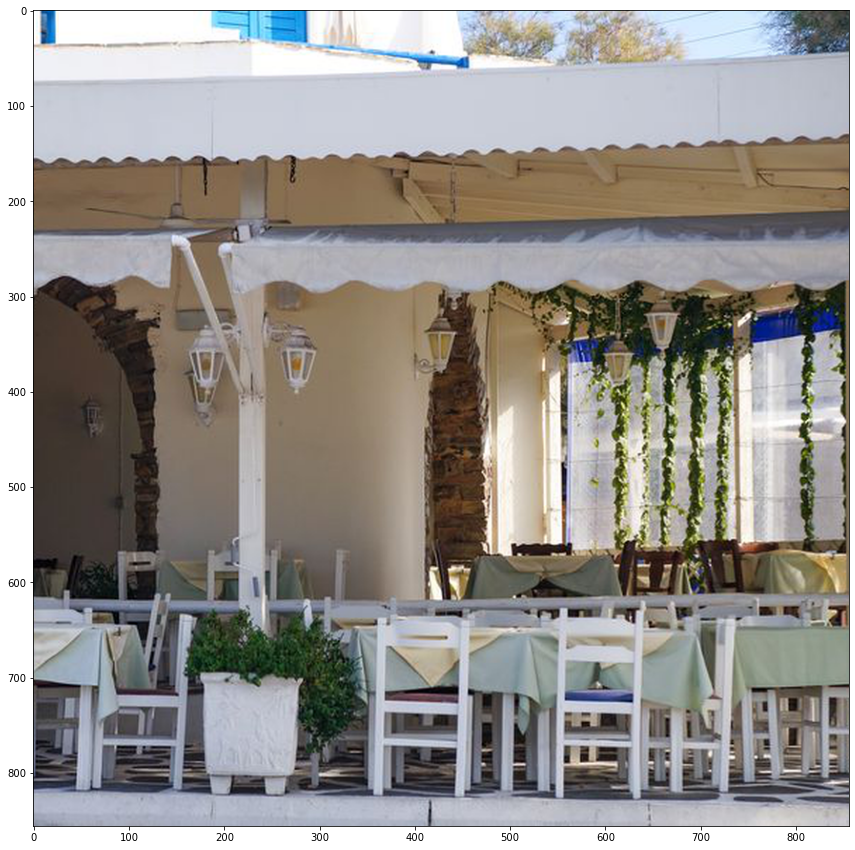

In [10]:
image_url = "https://img2.storyblok.com/800x0///f/95452/4390x3182/3f2fc821b3/greece-naxos-taverna.jpg"
download_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [12]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [14]:
def run_detector(detector, path):
    img = load_img(path)
    
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    
    result = {key:value.numpy() for key,value in result.items()}
    
    print("Found %d objects." %len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)
    
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])
    
    display_image(image_with_boxes)

Found 100 objects.
Inference time:  182.9665868282318
FOnt not found, using default font.


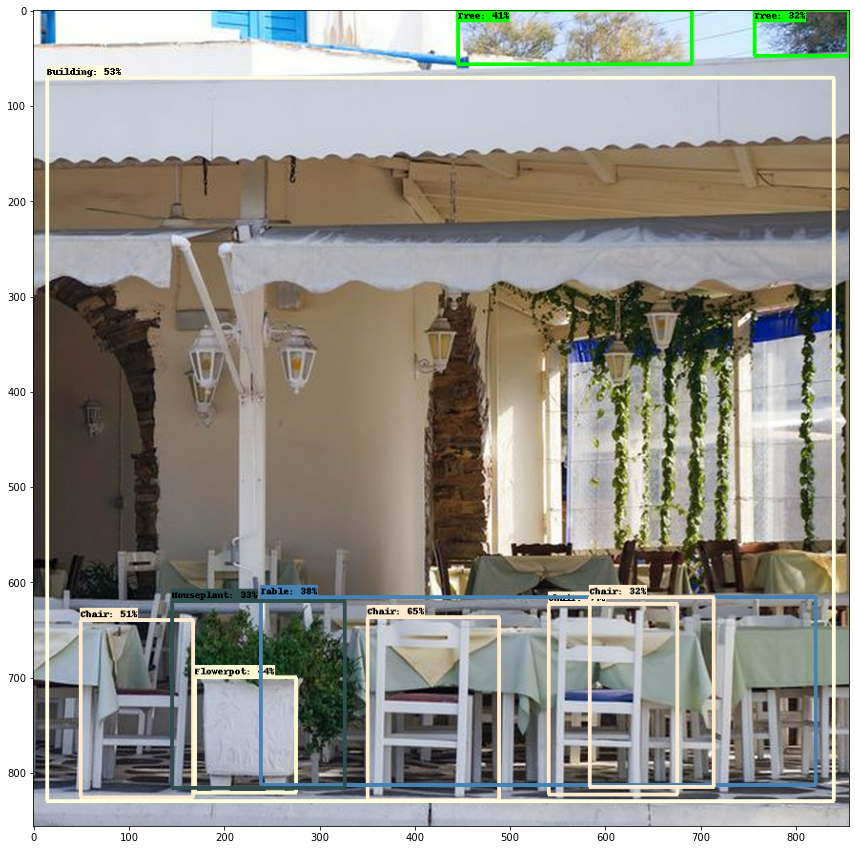

In [15]:
run_detector(detector, download_image_path)